# **Understanding Credit Insecurity: A Data-Driven Segmentation of American Households (Using the 2022 Survey of Consumer Finances)**
---

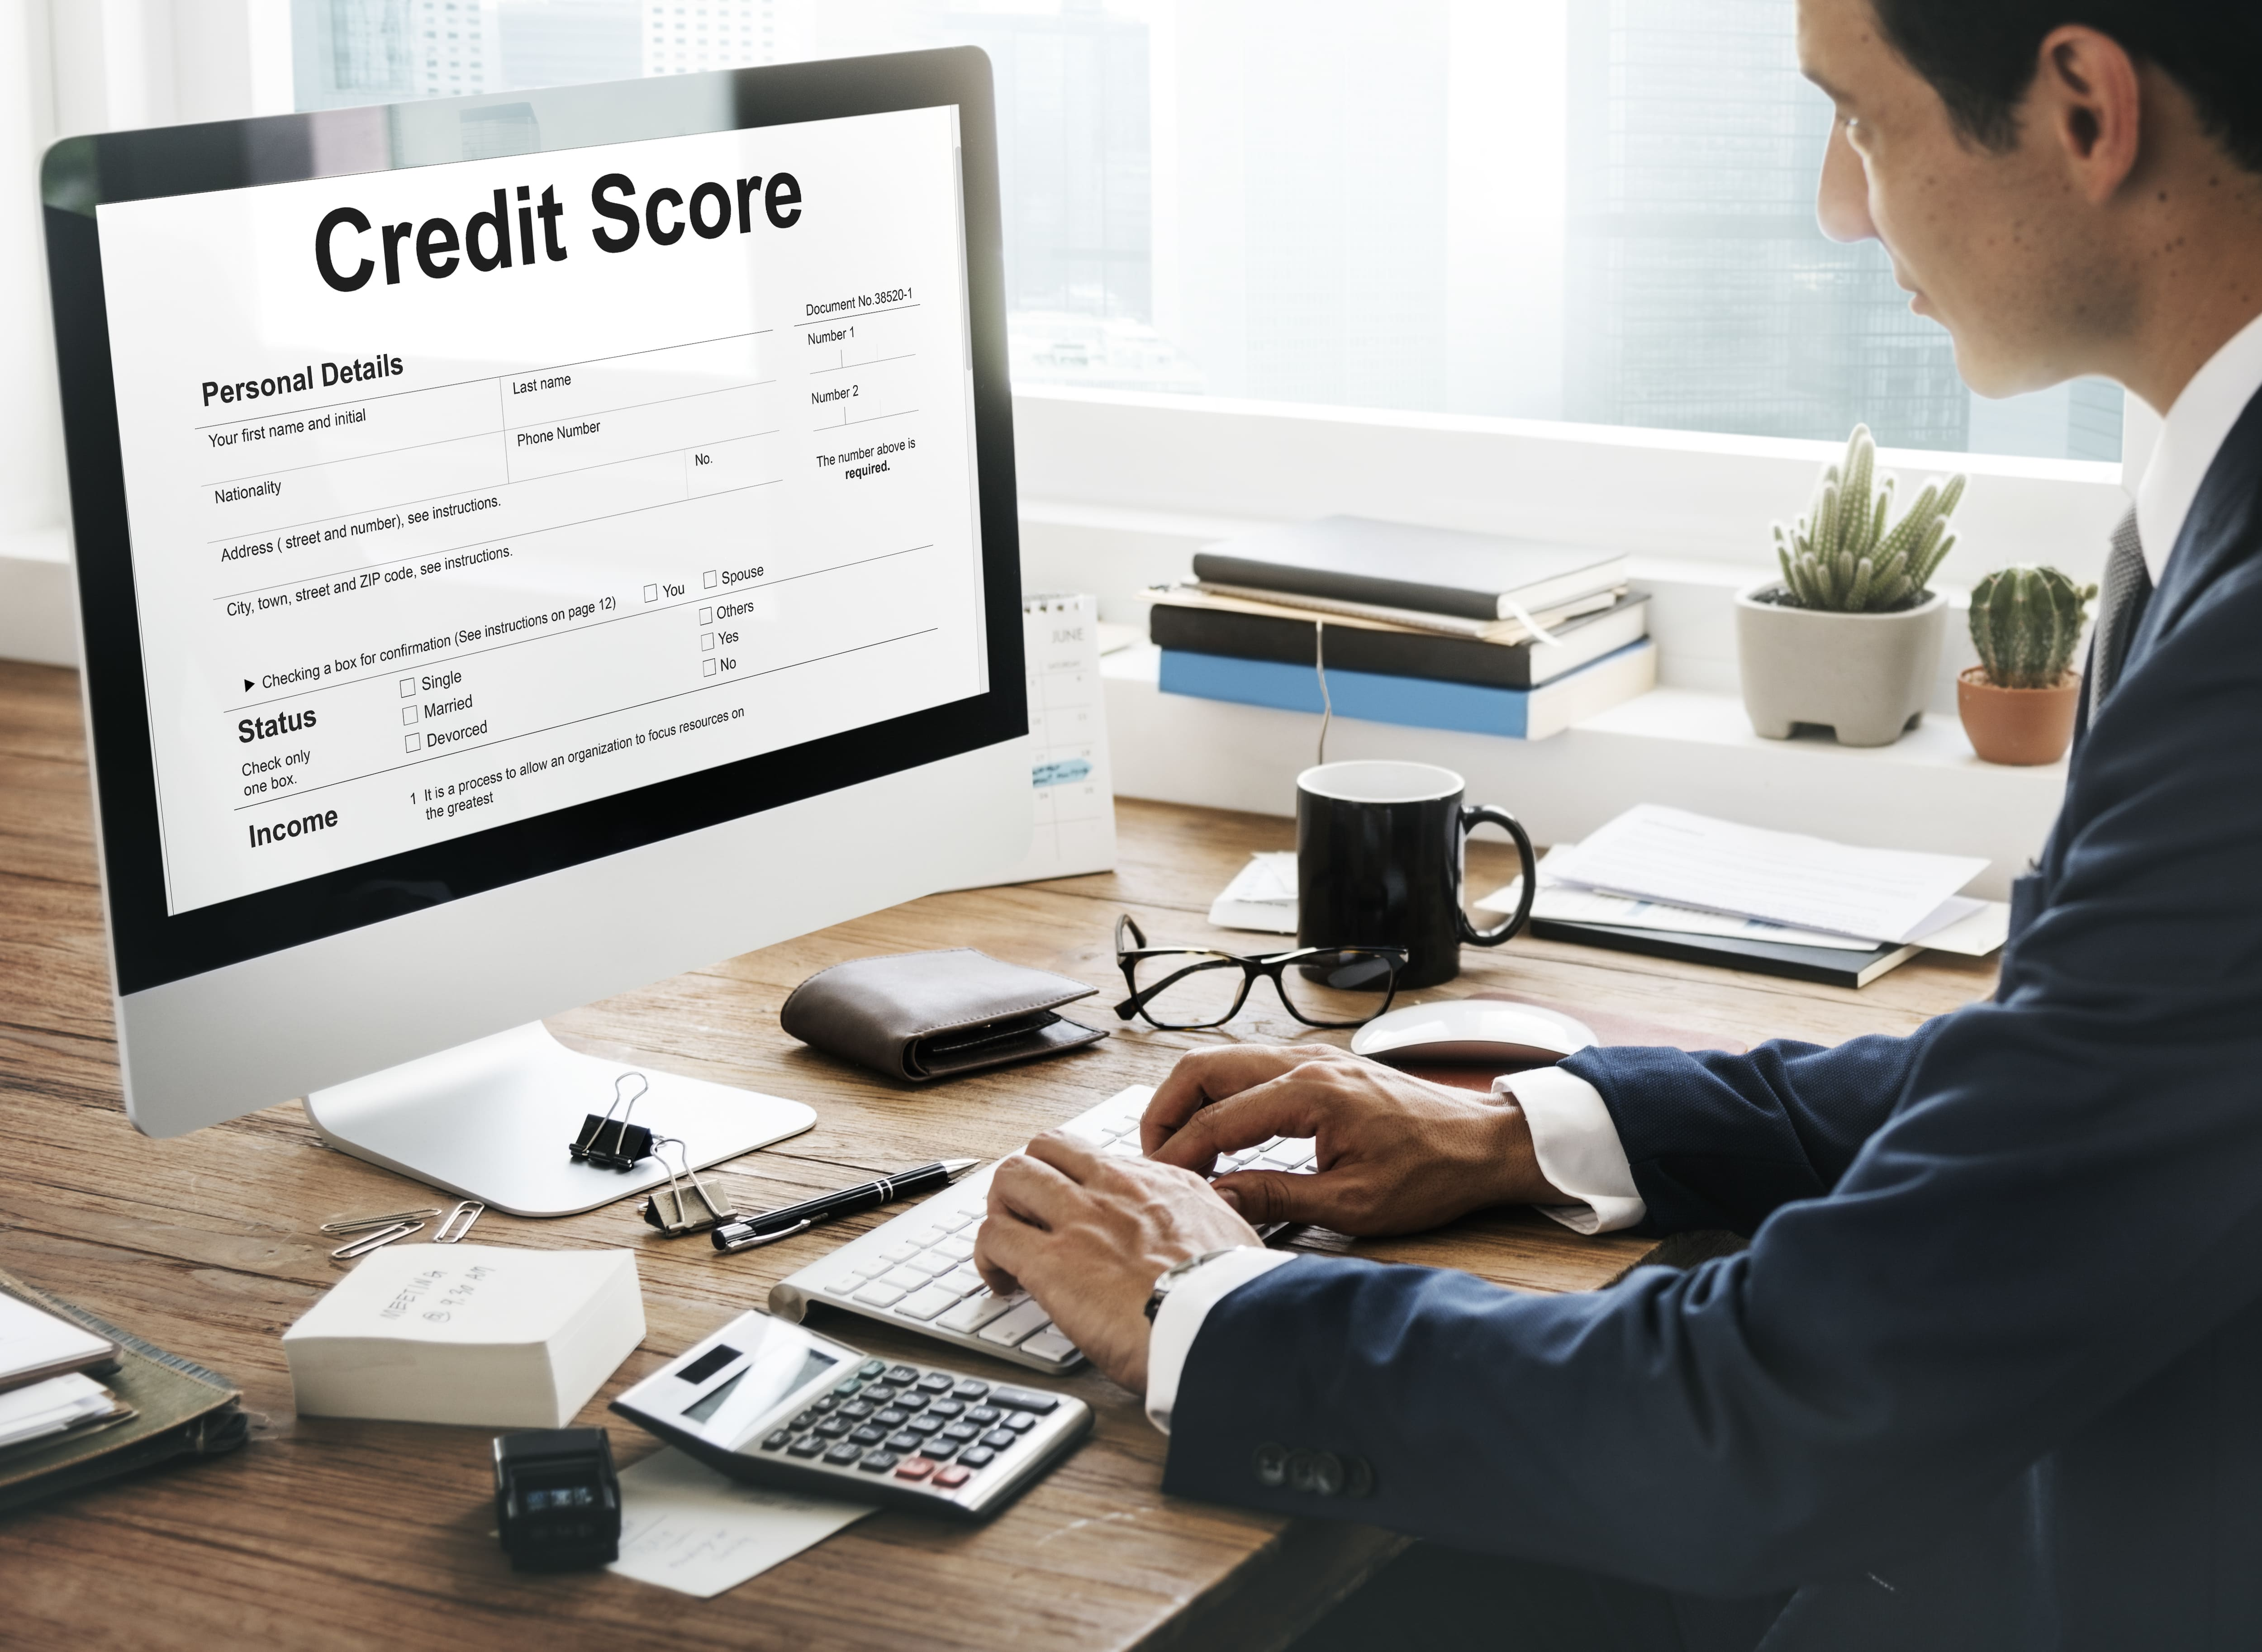



Every three years, the U.S. Federal Reserve conducts the **Survey of Consumer Finances (SCF)** to collect detailed information on the financial well-being of households across the country. In the 2022 edition, thousands of data points were gathered, ranging from income levels and debt obligations to demographic profiles and financial behavior. In this project, that data becomes the basis for a practical exploration. The task begins with identifying households that report difficulty accessing credit - a critical issue with implications for economic participation. From there, the goal shifts to organizing these households into distinct groups based on shared financial and demographic characteristics.

To achieve this, the project applies an unsupervised machine learning technique known as **K-Means Clustering**. The data is first prepared through feature selection and dimensionality reduction using **Principal Component Analysis (PCA)**, and then segmented using the k-means algorithm. The output is a set of well-defined clusters that reveal patterns within the credit-constrained population. To ensure the results are accessible and usable, the final step is the development of a web-based dashboard using **Plotly Dash**. This web application allows users to interact with the data, compare clusters, and derive insights that can inform further analysis or decision-making in fields like marketing, public policy, or financial services.

---

**PS.: This project was carried out using Google Colab**

---

## **Watch the Demo Video of the App**

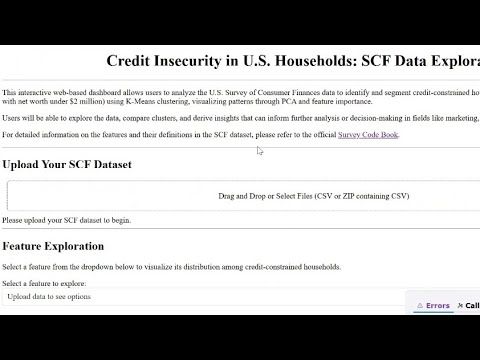

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('KGRoMZItneQ', width=640, height=360)

## **Let's Get Started!!**

In [ ]:
# Install the neccessary packages
!pip install dash dash-bootstrap-components requests plotly
!pip install python-dotenv
!pip install pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.1
    Uninstalling Flask-3.1.1:
      Successfully uninstalled Flask-3.1.1


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import zipfile
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats.mstats import trimmed_var
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import dash
from dash import dcc, html, Input, Output, State, callback, callback_context
import dash_bootstrap_components as dbc
import base64
import io

You can download the dataset [here](https://www.federalreserve.gov/econres/files/scfp2022excel.zip).The original file is huge so the file has been compressed from about 21MB to 2MB. We will be loading the compressed file named `scfp2022excel.zip`

In [ ]:
# Get the size of the compressed file
compressed_file_size = os.path.getsize("/content/drive/MyDrive/My_Portfolio_Projects/Project_Three/scfp2022excel.zip") # insert your file path
compressed_file_size_mb = compressed_file_size / (1024**2)  # Convert bytes to MB
print(f"Compressed file size: {compressed_file_size_mb: .2f} MB")

Compressed file size:  2.13 MB


In [ ]:
# Load the compressed file
df = pd.read_csv("/content/drive/MyDrive/My_Portfolio_Projects/Project_Three/scfp2022excel.zip")
print("df shape:", df.shape)
df.head()

df shape: (22975, 357)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,3027.956120,2,70,5,9,3,2,2,...,4,2,4,2,1,8,3,3,2,1
1,1,12,3054.900065,2,70,5,9,3,2,2,...,4,2,5,2,1,8,3,3,2,1
2,1,13,3163.637766,2,70,5,9,3,2,2,...,4,2,4,2,1,8,3,3,1,1
3,1,14,3166.228463,2,70,5,9,3,2,2,...,3,2,4,1,1,6,3,2,1,1
4,1,15,3235.624715,2,70,5,9,3,2,2,...,3,2,4,2,1,8,3,3,1,1


Our dataset contains 357 features with 22,975 observations. Here are the full meanings of the first five acronyms in the dataset:

* **YY1:** Case ID
* **Y1:** Case ID with implicate number
* **WGT:** 	Sample weight
* **HHSEX:** Gender of household reference person
* **AGE:** Age of reference person

For more info on the remaining features visit the latest survey code book [here](https://sda.berkeley.edu/sdaweb/docs/scfcomb2022/DOC/hcbkfx0.htm). On the website, you can click on a feature to get more details about the feature. For this project, we're going to focus on households that have **been turned down for credit** or **feared being denied credit** in the past 5 years. These households are identified in the **TURNFEAR** column.

In [ ]:
df.TURNFEAR.unique()

array([0, 1])

In [ ]:
df.TURNFEAR.value_counts()

,count
TURNFEAR,
0,19136
1,3839


This shows that 19,136 households have not been turned down for credit or feared being denied credit for the past five years, while only 3,839 households have been.

 Let's further examine the 3,839 households that have been turned down for credit or feared being denied credit for the past five years.

In [ ]:
df_fear = df[df.TURNFEAR == 1]
print("df_fear shape:", df_fear.shape)
df_fear.head()

df_fear shape: (3839, 357)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
20,5,51,7191.481109,2,19,1,8,2,1,0,...,1,3,1,2,1,2,5,4,2,2
21,5,52,7352.487205,2,19,1,8,2,1,0,...,1,3,1,2,1,2,5,4,2,2
22,5,53,7270.703541,2,19,1,8,2,1,0,...,1,3,1,3,1,2,5,5,2,2
23,5,54,7383.866597,2,19,1,8,2,1,0,...,1,3,1,3,1,2,5,5,2,2
24,5,55,7330.537669,2,19,1,8,2,1,0,...,1,3,1,2,1,2,5,4,2,2


### **Age Group**

We can get data on this from the `AGECL` column (which represents the age group of the reference person).

In [ ]:
age_groups = df_fear["AGECL"].unique()
age_groups

array([1, 4, 2, 3, 5, 6])

This shows that there are six age groups in the dataset. From the [code book](https://sda.berkeley.edu/sdaweb/docs/scfcomb2022/DOC/hcbk0001.htm#AGE), we can see that each age group signifies an age range. Here's a screenshot from the code book:

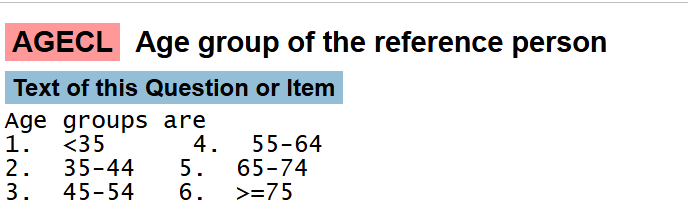

In [ ]:
# Replace the numerical categories for Age Groups with the true group names
AGECL_dict = {
    1: "Under 35",
    2: "35-44",
    3: "45-54",
    4: "55-64",
    5: "65-74",
    6: "75 or Older",
}

AGECL = df_fear["AGECL"].replace(AGECL_dict)
print("AGECL shape:", AGECL.shape)
AGECL.head()

AGECL shape: (3839,)


,AGECL
20,Under 35
21,Under 35
22,Under 35
23,Under 35
24,Under 35


In [ ]:
# Get the counts in each age group
age_group_counts = AGECL.value_counts()
print(type(age_group_counts))
age_group_counts

<class 'pandas.core.series.Series'>


,count
AGECL,
35-44,936
Under 35,917
45-54,802
55-64,682
65-74,398
75 or Older,104


In [ ]:
df_age = age_group_counts.reset_index()
df_age.columns = ["Age Group", "Frequency (count)"]

fig = px.bar(
    df_age,
    x="Age Group",
    y="Frequency (count)",
    title="Credit Fearful: Age Groups",
    labels={"Age Group": "Age Group", "Frequency (count)": "Frequency (count)"}
)
fig.show()


This shows that majority of the household owners that were turned down for credit or feared being denied credit for the past five years are between 35-44 years of age, while those at 75 or older were the least. This tells us that many of those who fear being denied credit are younger. Next, lets look at the actual ages of these household owners by examining the `AGE` column.

In [ ]:
# Plot histogram of "AGE"
fig = px.histogram(
    df_fear,
    x="AGE",
    nbins=10,
    labels={"AGE": "Age"},
    title="Credit Fearful: Age Distribution"
)
fig.update_layout(yaxis_title="Frequency (count)")
fig.show()


Now that we have delved deeper into the actual ages of the household owners, we can see that there are three major age groups in this dataset: the highest is the 40-50 age group followed by the 30–40 age group and the 50–60 age range. Hence, the majority of individuals fall between 30 and 60 years old, indicating that the credit fearfulness is more common in middle-aged groups.

Typically, those in the middle-age group have shorter credit histories and fewer established lines of credit. As a result, lenders may be more cautious extending credit, making young borrowers prone to denial and subsequent anxiety about future applications. In addition, they may not yet have experience navigating the credit system, such as improving a credit score or using secured credit cards to build credit. The sense of “not knowing how” can lead to higher fear of rejection.

### **Race/Ethnicity**

We can get data on this from the `RACE` column (which represents the race/ethnicity of respondent).

In [ ]:
df_fear["RACE"].unique()

array([2, 1, 3, 5, 4])

This shows that there are five different races in the dataset. From the [code book](https://sda.berkeley.edu/sdaweb/docs/scfcomb2022/DOC/hcbk0001.htm#AGE), here is what each category means:

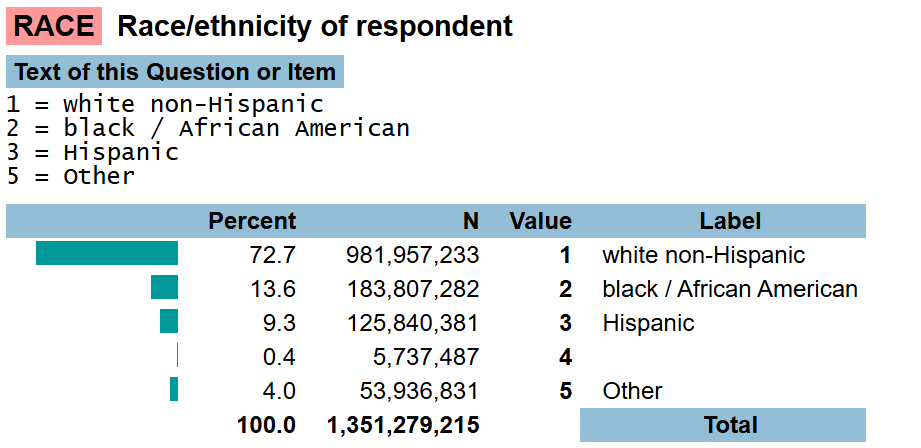

You can see that the *4* category is not defined. Generally, it is most likely **Asian**.

In [ ]:
# Replace the numerical categories for RACE with the true group names
race_dict = {
    1: "White/Non-Hispanic",
    2: "Black/African-American",
    3: "Hispanic",
    4: "Asian",
    5: "Other",
}
race = df_fear["RACE"].replace(race_dict)
race_value_counts = race.value_counts(normalize=True)

# Create a DataFrame for Plotly Express
race_df = race_value_counts.rename_axis('Race').reset_index(name='Frequency')

# Create the bar chart
fig = px.bar(race_df,
             x='Frequency',
             y='Race',
             orientation='h', # Horizontal bar chart
             title="Credit Fearful Respondents in Each Racial Group",
             labels={'Frequency':'Frequency (%)'} # Customize x-axis label
            )

fig.update_xaxes(range=[0, 1]) # Set x-axis limits
fig.show()

This looks like the 'White/Non-Hispanic' race is most fearful of being denied credit but is it really the case? This might be because of the larger population of the 'White/Non-Hispanic' race compared to the other races as shown in the [code book](https://www.google.com/url?q=https%3A%2F%2Fsda.berkeley.edu%2Fsdaweb%2Fdocs%2Fscfcomb2022%2FDOC%2Fhcbk0001.htm%23AGE)

In [ ]:
race = df["RACE"].replace(race_dict)
# Calculate normalized value counts
race_value_counts = race.value_counts(normalize=True)

# Create a DataFrame for Plotly Express
race_df = race_value_counts.rename_axis('Race').reset_index(name='Frequency')

# Create the bar chart
fig = px.bar(race_df,
             x='Frequency',
             y='Race',
             orientation='h', # Horizontal bar chart
             title="Count of SCF Respondents in Each Racial Group",
             labels={'Frequency':'Frequency (%)'} # Customize x-axis label
            )

fig.update_xaxes(range=[0, 1]) # Set x-axis limits
fig.show()

 A more telling way to see which racial group is most credit fearful is to compare each group’s percentage among the credit-fearful population to its percentage in the overall sample:

 * If a group’s share among the credit fearful is larger than (or about equal to) its share in the total sample, that group is overrepresented (i.e., more likely than average to report credit fear).

* If a group’s share among the credit fearful is smaller than its share in the total sample, that group is underrepresented (less likely than average to report credit fear).

From the plots, we can see that the 'White/Non-Hispanic' race make up about 62% of the total sample but about 39% of the credit fearful sample, while the 'Black/African-American' race make up about 15% of the total sample but about 34% of the credit fearful sample. This shows that the 'Black/African-American' households seem to be the most credit fearful followed by the Hispanic households and the 'Other' race households.

### **Income Levels**

We are going to examine how the income levels of the respondents affect their credit fearfulness. We will consider not just the credit fearful respondents but also the credit fearless respondents.

In [ ]:
# Get the unique income groups from the INCCAT column
df["INCCAT"].unique()

array([2, 5, 6, 4, 3, 1])

This shows that there are six different income groups in the dataset. From the [code book](https://sda.berkeley.edu/sdaweb/docs/scfcomb2022/DOC/hcbk0007.htm#INCCAT), here is what each category means:

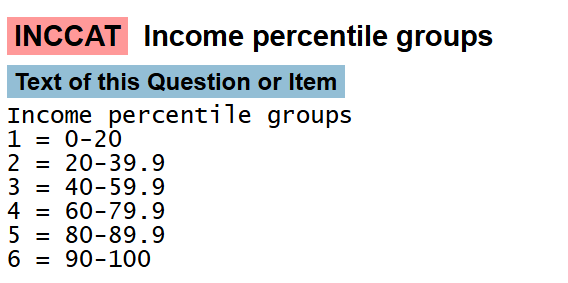

Next, we are going to show the distribution of income categories within households that have and have not been turned down for credit or feared being denied credit in the past 5 years.

In [ ]:
inccat_dict = {
    1: "0-20",
    2: "20-39.9",
    3: "40-59.9",
    4: "60-79.9",
    5: "80-89.9",
    6: "90-100",
}

# calculates the relative frequency of each income group
# for households that have either experienced credit fear (TURNFEAR = 1) or not (TURNFEAR = 0)

df_inccat = (df["INCCAT"].replace(inccat_dict) # Replace numerical categories with the true group names
                .groupby(df["TURNFEAR"])
                .value_counts(normalize=True)
                .rename("Relative Frequency")
                .to_frame().reset_index()
)

print("df_inccat shape:", df_inccat.shape)
df_inccat

df_inccat shape: (12, 3)


,TURNFEAR,INCCAT,Relative Frequency
0,0,90-100,0.303982
1,0,60-79.9,0.162312
2,0,40-59.9,0.144492
3,0,0-20,0.140050
4,0,20-39.9,0.139162
5,0,80-89.9,0.110002
6,1,0-20,0.340714
7,1,20-39.9,0.266476
8,1,40-59.9,0.205001
9,1,60-79.9,0.112529


In [ ]:
# Convert TURNFEAR to a string type
df_inccat['TURNFEAR'] = df_inccat['TURNFEAR'].astype(str)

# Replace numerical categories in TURNFEAR column
df_inccat['TURNFEAR'] = df_inccat['TURNFEAR'].replace({
    '0': 'Credit Fearless',
    '1': 'Credit Fearful'
})

# Plot a side-by-side bar chart
fig = px.bar(
    df_inccat,
    x="INCCAT",
    y="Relative Frequency",
    color="TURNFEAR",
    barmode='group',
    category_orders={"INCCAT": list(inccat_dict.values())},
    labels={"INCCAT": "Income Category", "Relative Frequency": "Frequency (%)"},
    title="Income Distribution: Credit Fearful vs. Non-fearful"
)
fig.show()

The bottom 20 percent (the lowest income percentile group) has the most fearful respondents (likely due to tighter finances), while the top income percentile group (highest 10 percent) has the most credit fearless respondents. Low-income individuals often lack financial buffers (such as savings or assets), which lenders see as risk factors. Denials may reinforce a perception that “I don’t earn enough,” intensifying fear about being rejected again. However, the top decile also shows a notable share of fearfulness, possibly reflecting larger debts or prior negative experiences with credit.

### **Asset Levels**

We are going to look at the asset levels of both the credit fearful and credit fearless respondents and determine how their asset levels affect their credit fearfullness.

In [ ]:
df['ASSETCAT'].unique()

array([4, 5, 6, 1, 3, 2])

This shows that there are six different asset level groups in the dataset. From the [code book](https://sda.berkeley.edu/sdaweb/docs/scfcomb2022/DOC/hcbk0002.htm#ASSET), here is what each category means:

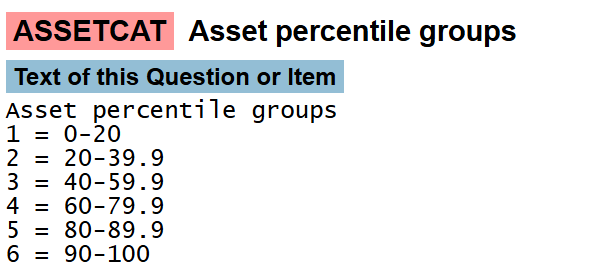

Next, we are going to show the distribution of asset categories within households that have and have not been turned down for credit or feared being denied credit in the past 5 years.

In [ ]:
assetcat_dict = {
    1: "0-20",
    2: "20-39.9",
    3: "40-59.9",
    4: "60-79.9",
    5: "80-89.9",
    6: "90-100",
}

# calculates the relative frequency of each asset group
# for households that have either experienced credit fear (TURNFEAR = 1) or not (TURNFEAR = 0)

df_assetcat = (df["ASSETCAT"].replace(inccat_dict) # Replace numerical categories with the true group names
                .groupby(df["TURNFEAR"])
                .value_counts(normalize=True)
                .rename("Relative Frequency")
                .to_frame().reset_index()
)

print("df_assetcat shape:", df_assetcat.shape)
df_assetcat

df_assetcat shape: (12, 3)


,TURNFEAR,ASSETCAT,Relative Frequency
0,0,90-100,0.322899
1,0,60-79.9,0.174383
2,0,20-39.9,0.138273
3,0,0-20,0.133779
4,0,40-59.9,0.120036
5,0,80-89.9,0.110629
6,1,0-20,0.474603
7,1,20-39.9,0.237822
8,1,40-59.9,0.127377
9,1,60-79.9,0.085178


In [ ]:
# Convert TURNFEAR to a string type
df_assetcat['TURNFEAR'] = df_assetcat['TURNFEAR'].astype(str)

# Replace numerical categories in TURNFEAR column
df_assetcat['TURNFEAR'] = df_assetcat['TURNFEAR'].replace({
    '0': 'Credit Fearless',
    '1': 'Credit Fearful'
})

# Plot a side-by-side bar chart
fig = px.bar(
    df_assetcat,
    x="ASSETCAT",
    y="Relative Frequency",
    color="TURNFEAR",
    barmode='group',
    category_orders={"ASSETCAT": list(assetcat_dict.values())},
    labels={"ASSETCAT": "Asset Category", "Relative Frequency": "Frequency (%)"},
    title="Asset Distribution: Credit Fearful vs. Non-fearful"
)
fig.show()

We can see a positive correlation between the asset level and income level. Like the income level, the lowest asset percentile group has the most fearful respondents, while the top asset percentile group has the most credit fearless respondents. This might be because lenders view high-asset respondents as less risky, which reduces the anxiety about future denials.  However, some high-asset respondents also showed a notable share of fearfulness, possibly reflecting larger debts or prior negative experiences with credit.

### **Education Levels**

We are going to look at the education levels (the highest degree attained) of both the credit fearful and credit fearless respondents and determine how their education levels affect their credit fearfullness.

In [ ]:
df['EDUC'].unique()

array([ 9, 12, 14,  8, 13, 10,  4, 11,  3,  6,  2,  5,  1,  7, -1])

This shows that there are 15 different education levels in the dataset. From the [code book](https://sda.berkeley.edu/sdaweb/docs/scfcomb2022/DOC/hcbk0001.htm#EDUC), here is what each category means:



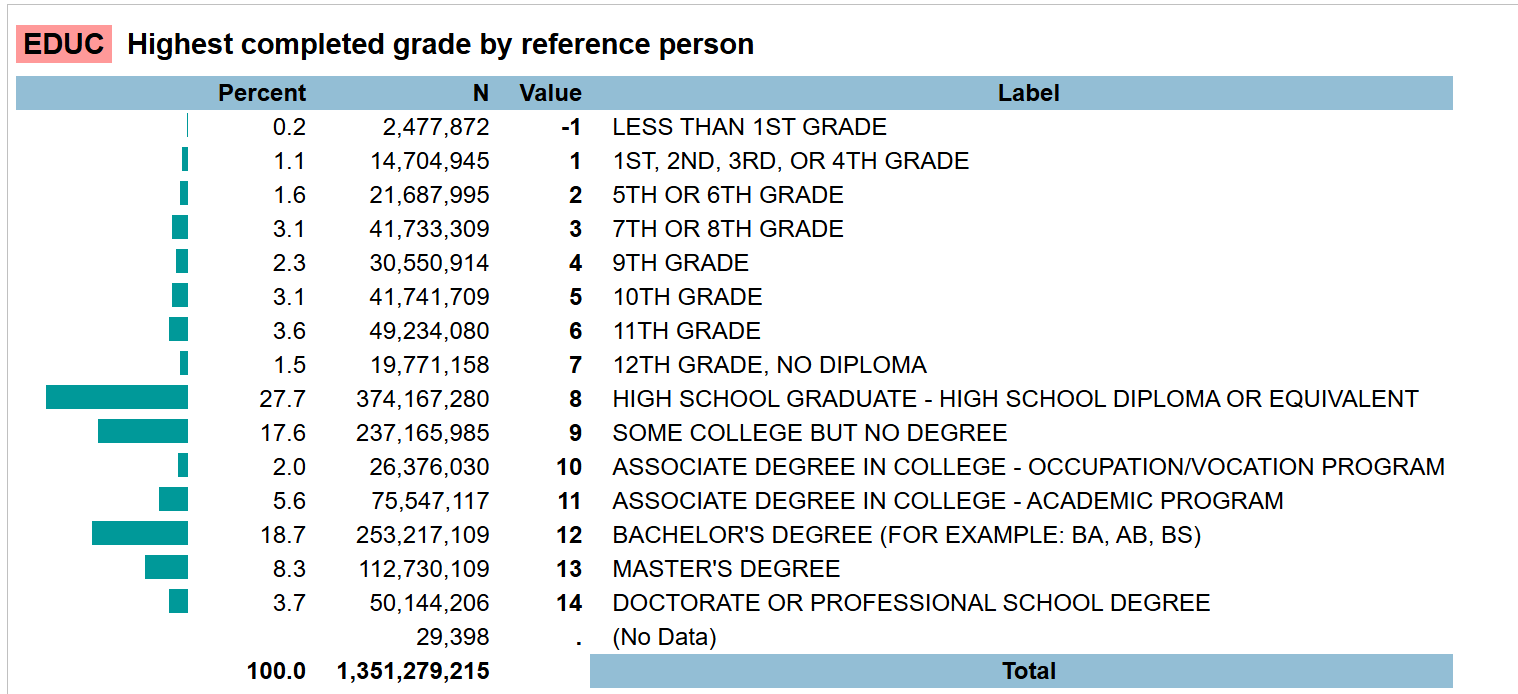

Next, we are going to show the distribution of education levels (the highest degree attained) of the respondents that have and have not been turned down for credit or feared being denied credit in the past 5 years.

In [ ]:
# calculates the relative frequency of each education level
# for households that have either experienced credit fear (TURNFEAR = 1) or not (TURNFEAR = 0)

df_educ = (df["EDUC"].groupby(df["TURNFEAR"])
                .value_counts(normalize=True)
                .rename("Relative Frequency")
                .to_frame().reset_index()
)

print("df_educ shape:", df_educ.shape)
df_educ

df_educ shape: (30, 3)


,TURNFEAR,EDUC,Relative Frequency
0,0,12,0.278689
1,0,8,0.174383
2,0,13,0.158967
3,0,9,0.111727
4,0,14,0.108539
5,0,10,0.049122
6,0,11,0.041283
7,0,7,0.016722
8,0,6,0.012176
9,0,4,0.010974


In [ ]:
# Convert TURNFEAR to a string type
df_educ['TURNFEAR'] = df_educ['TURNFEAR'].astype(str)

# Replace numerical categories in TURNFEAR column
df_educ['TURNFEAR'] = df_educ['TURNFEAR'].replace({
    '0': 'Credit Fearless',
    '1': 'Credit Fearful'
})

# Plot a side-by-side bar chart
fig = px.bar(
    df_educ,
    x="EDUC",
    y="Relative Frequency",
    color="TURNFEAR",
    barmode='group',
    labels={"EDUC": "Education Category", "Relative Frequency": "Frequency (%)"},
    title="Education Distribution: Credit Fearful vs. Non-fearful"
)
fig.show()

We can see that higher levels of completed education generally correlate with lower credit fearfulness. A much higher proportion of credit-fearful respondents have only a high school diploma, while university degrees are more common among the credit fearless respondents. Individuals with lower educational attainment are more likely to face uncertain or lower-paying jobs, have less exposure to credit literacy, and thus feel more vulnerable to being denied credit — resulting in higher credit fearfulness.

### **Correlation Between "AGE", "ASSET", "HOUSES", "INCOME", "DEBT", and "EDUC".**

We are going to get a grasp of the relationships among the variables, namely "AGE", "ASSET", "HOUSES", "INCOME", "DEBT", and "EDUC" in both the overall sample and the credit fearful sample. Note:

* **AGE:** Age of household respondent
* **ASSET:** Total value of assets held by household
* **HOUSES:** Total value of primary residence of household
* **INCOME:** Total amount of income of household
* **DEBT:** Total value of debt held by household
* **EDUC:** Highest completed grade by respondent

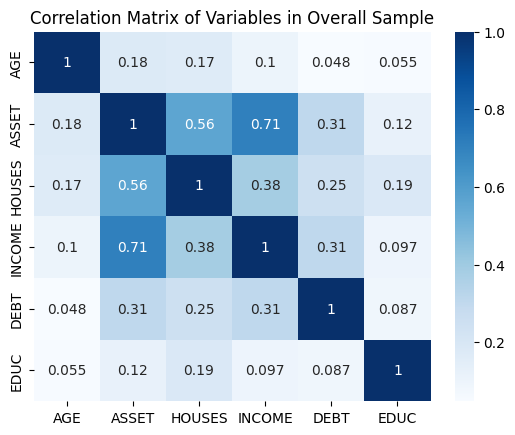

In [ ]:
# Plot correlation matrix of variables in overall sample
cols = ["AGE", "ASSET", "HOUSES", "INCOME", "DEBT", "EDUC"]
corr = df[cols].corr()
sns.heatmap(corr, cmap='Blues', annot=True)
plt.title("Correlation Matrix of Variables in Overall Sample")
plt.show()

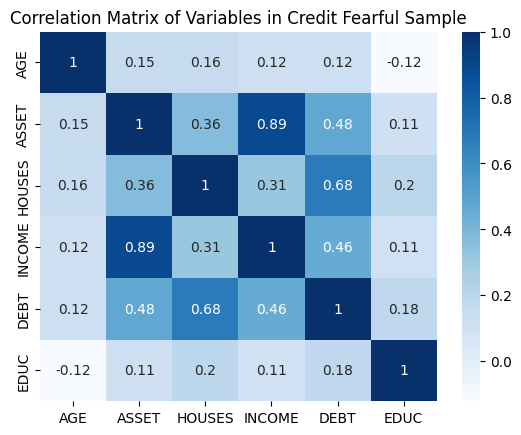

In [ ]:
# Plot correlation matrix of variables in credit fearful sample (df_fear)
cols = ["AGE", "ASSET", "HOUSES", "INCOME", "DEBT", "EDUC"]
corr = df_fear[cols].corr()
sns.heatmap(corr, cmap='Blues', annot=True)
plt.title("Correlation Matrix of Variables in Credit Fearful Sample")
plt.show()

We can highlght the following from the correlation matrices:
* The **INCOME-ASSET** correlation is stronger in the credit fearful sample (0.89) than in the overall sample (0.71). This could mean income drives asset accumulation more directly for those who are credit fearful. Because they may have trouble obtaining credit, they might rely heavily on their own income to build assets.
* The **HOUSES-ASSET** correlation is weaker in the credit fearful sample (0.36) than in the overall sample (0.56). In the fearful group, the value of one’s primary residence is less tied to total assets. This could mean some fearful households may be renters (reducing the direct link between home value and total assets), or some may have diversified asset holdings (business equity, savings, or retirement accounts) that overshadow the value of their home.
* The **HOUSES-DEBT** correlation is stronger in the credit fearful sample (0.68) than in the overall sample (0.25). Among the credit fearful, a pricey home strongly correlates with high debt, indicating a main source of credit anxiety could be a significant mortgage burden.

# **K-Means Clustering Using HOUSES and DEBT as Features**

We are going to use the K-Means Clustering algorithms to cluster the SCF respondents according to HOUSES (Household value) and DEBT (Household Debt).

**K-Means** is an unsupervised clustering algorithm that partitions a dataset into *k* clusters based on feature similarity. It starts by randomly selecting *k* initial cluster centroids. Each data point is then assigned to the nearest centroid, forming *k* clusters. Next, the centroids are updated by computing the mean of all points in each cluster. This process of assignment and centroid update repeats iteratively until the centroids stabilize (i.e., they no longer change significantly) or a predefined number of iterations is reached. The algorithm aims to minimize the within-cluster variance (sum of squared distances between points and their assigned centroid).

In [ ]:
# Create scatter plot of "HOUSES" vs "DEBT" for credit fearful respodents
fig = px.scatter(
    df,
    x=df['DEBT'] / 1e6,
    y=df['HOUSES'] / 1e6,
    labels={"DEBT": "Household Debt [$1M]", "HOUSES": "Household Value [$1M]"},
    title="Credit Fearful: Household Value vs. Household Debt"
)

fig.show()


Looking at the scatter plot, we can see that the data points form about 4 different clusters. We are going to use the K-Means algorithm to clearly define these clusters.

In [ ]:
# Create a feature matrix for the clustering algorithm
X = df[['DEBT','HOUSES']]

print("X shape:", X.shape)
X.head()

X shape: (22975, 2)


,DEBT,HOUSES
0,195000,674000
1,213000,858000
2,279000,757000
3,549000,710000
4,223000,765000


### **Building the K-Means Model**

From the scatter plot, it seems like there are 4 clusters. But how sure are we? We will need to find the optimal number of clusters (k) for our K-Means clustering model using two methods: inertia and the silhouette score. By examining the inertia and silhouette scores for each potential value of `k`, we can then determine the optimal `k` value, balancing low inertia with a high silhouette score.

In [ ]:
n_clusters = range(2, 13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    inertia_errors.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X, model.labels_))

# Create a Pandas DataFrame to store the results
results = pd.DataFrame({
    'Number of Clusters (k)': n_clusters,
    'Inertia': inertia_errors,
    'Silhouette Score': silhouette_scores
})

# Display the results table
display(results)

,Number of Clusters (k),Inertia,Silhouette Score
0,2,2.493688e+17,0.934523
1,3,1.631703e+17,0.922545
2,4,1.099620e+17,0.893449
3,5,9.060352e+16,0.802447
4,6,6.710159e+16,0.799503
5,7,5.137737e+16,0.795095
6,8,4.131843e+16,0.793644
7,9,3.463433e+16,0.791581
8,10,3.157457e+16,0.788543
9,11,2.579532e+16,0.750032


Let's visualize these results

In [ ]:
# Convert data to a DataFrame for Plotly
df_inertia = pd.DataFrame({"Number of Clusters": n_clusters, "Inertia": inertia_errors})

# Create the line plot using Plotly Express
fig = px.line(df_inertia, x="Number of Clusters", y="Inertia",
              title="K-Means Model: Inertia vs Number of Clusters",
              markers=True)

fig.show()

This plot shows the **Elbow Method** for selecting the optimal number of clusters in K-Means clustering. As the number of clusters increases, inertia (sum of squared distances from points to their assigned cluster centers) decreases. This is expected because adding more clusters makes each cluster tighter. However, while increasing the number of clusters reduces inertia, it also increases model complexity. Choosing the *elbow point* helps balance accuracy and simplicity.

The curve has a noticeable bend (elbow), which is typically considered the optimal number of clusters. Based on the plot, the elbow point appears to be around 4 or 5 clusters. After a certain point (e.g., beyond 6 clusters), the decrease in inertia is marginal, implying that additional clusters are not significantly improving the clustering structure.

In [ ]:
# Convert data to a DataFrame for Plotly
df_silhouette = pd.DataFrame({"Number of Clusters": n_clusters, "Silhouette Score": silhouette_scores})

# Create the line plot using Plotly Express
fig = px.line(df_silhouette, x="Number of Clusters", y="Silhouette Score",
              title="K-Means Model: Silhouette Score vs Number of Clusters",
              markers=True)

fig.show()

The silhouette score measures cluster quality, with values ranging from -1 to 1. Higher values indicate well-separated and well-defined clusters. We can see from the plot that as the number of clusters increases, the silhouette score decreases. This suggests that increasing the number of clusters leads to poorer-defined clusters, possibly due to over-segmentation of the data.

The highest silhouette scores occur for 2 to 4 clusters, indicating that fewer clusters provide better separation and structure. After 4 clusters, the score drops significantly, suggesting that more clusters reduce cohesion and separation quality.

Based on both inertia and silhouette score plots, 4 clusters is likely the best choice for this dataset.

In [ ]:
# Build the final model
final_model = KMeans(n_clusters=4,random_state=42)
# Fit model to data
final_model.fit(X)

KMeans(n_clusters=4, random_state=42)

In [ ]:
# Plot "HOUSES" vs "DEBT" with final_model labels
fig = px.scatter(
    df,
    x=df['DEBT'] / 1e6,
    y=df["HOUSES"] / 1e6,
    color=final_model.labels_.astype(str), # Convert labels to strings for categorical color
    labels={"x": "Household Debt [$1M]", "y": "Household Value [$1M]"},
    title="Credit Fearful: Household Value vs. Household Debt",
    category_orders={
        "color": [str(i) for i in range(final_model.n_clusters)]  # Ensures correct category order
    }
)

fig.show()


In [ ]:
# Get the cluster centers (the mean of the features within each cluster)
final_model.cluster_centers_

array([[  207041.36584265,   572331.31420232],
       [ 5116395.83333333, 47128541.66666667],
       [87280000.00000001, 16115384.61538462],
       [ 3462159.63855425, 10626583.58433736]])

Let's display these cluster centers in a more appropriate way.

In [ ]:
# Get cluster labels for each data point
labels = final_model.labels_

# Group the data by cluster labels
X_cluster_mean = X.groupby(labels)

# calculate the mean for each cluster
X_cluster_mean = X_cluster_mean.mean()
X_cluster_mean

,DEBT,HOUSES
0,2.072661e+05,5.727576e+05
1,5.116396e+06,4.712854e+07
2,8.728000e+07,1.611538e+07
3,3.464441e+06,1.064263e+07


In [ ]:
# Create side-by-side bar chart of `X_cluster_mean`

# Convert values to millions
X_cluster_mean_million = X_cluster_mean / 1e6

# Create a bar chart using Plotly
fig = px.bar(
    X_cluster_mean_million,
    barmode='group',
    labels={"index": "Cluster", "value": "Value [$1 million]"},
    title="Mean Household Value & Household Debt by Cluster"
)

fig.show()


Clusters 0 and 3 have low debt and home value, possibly indicating lower-income households or renters. Cluster 1 has a much higher debt level compared to other clusters. Cluster 1 could represent households that are highly leveraged (they owe more in debt relative to their home values) or in financially risky situations. Cluster 2 has the highest home value among all clusters, but its debt is not proportionally high. Cluster 2 could represent financially stable households with high home ownership (or equity) and relatively low debt.

These insights can help in the following ways:

* **Risk Assessment:** Cluster 1 (high debt, lower home value) indicates a high-risk group that may struggle with repayments. Banks may impose higher interest rates or stricter lending criteria.

* **Targeted Lending:** Cluster 2 (high home value, low debt) represents low-risk customers who might qualify for lower interest rates or larger loans.

* **Debt Restructuring:** Clusters 0 and 3, with relatively balanced debt and home values, might be good candidates for refinancing or debt consolidation offers.

* **Investment Strategies:** Investors looking for rental opportunities may target Cluster 1, where people may be unable to buy homes but still need housing. Since people in cluster 1 cannot afford homes but still need housing, they will more likely turn to renting.

# K-Means Clustering Using Five Features

Previously, we focused on clustering the overall respondents but now we will focus on clustering the credit fearful respondents. In addition, we will use five features instead of two as we did previously.

In [ ]:
# Get summary statistics of the networth of SCF respondents
df['NETWORTH'].describe()

,NETWORTH
count,2.297500e+04
mean,1.995640e+07
std,1.101707e+08
min,-5.555000e+05
25%,3.590750e+04
50%,3.845000e+05
75%,2.476105e+06
max,2.387781e+09


In [ ]:
# Get summary statistics of the networth of SCF respondents
df['HOUSES'].describe()

,HOUSES
count,2.297500e+04
mean,9.689703e+05
std,3.219532e+06
min,0.000000e+00
25%,0.000000e+00
50%,2.620000e+05
75%,7.500000e+05
max,1.132300e+08


You may have noticed that the data contains a few highly fincancially stable respondents. These respondents act as outliers in our data and they inflate the mean, making it unrepresentative of the dataset. Looking at the summary statistics of the networth of the SCF respondents, most of them have a networth of close to millions of dollars but there are a very few with a networth of billions of dollars that act as outliers. The same can be seen for the `HOUSES` (household value) column. Hence, we are going to select credit fearful respondents with networth under $2 million to minimize the effect of outliers.


We will be selecting the top five features to be used for building our K-Means model. A suitable way to select these features is by comparing the variance of the features. We should note that because variance is the squared deviation from the mean, it's heavily influenced by outliers. When the difference between the outliers and the mean are too far away from each other, the variance might not reveal the true information of how data points are distributed. In this case, we can calculate `trimmed variance`, which is the variance calculated excluding the largest and the smallest data points, thereby removing outliers.

In [ ]:
mask=(df["TURNFEAR"]==1) & (df["NETWORTH"]<2e6)
df_fear_mask =df[mask]
print("df_fear_mask shape:", df_fear_mask.shape)
# Get the summary statistics of the NETWORTH column
df_fear_mask.NETWORTH.describe()

df_fear_mask shape: (3672, 357)


,NETWORTH
count,3.672000e+03
mean,1.048240e+05
std,2.582780e+05
min,-4.286500e+05
25%,1.375000e+01
50%,1.111500e+04
75%,9.500100e+04
max,1.997750e+06


The maximum net worth in the credit fearful sample has been reduced from \$2.38 billion to less than $2 million.

In [ ]:
# Calculate variance in credit fearful sample, get 10 largest features
top_ten_var = df_fear_mask.var().sort_values().tail(10)

# Create horizontal bar chart of `top_ten_var`
fig = px.bar(x=top_ten_var,y=top_ten_var.index, title="Credit Fearful: Top Ten High Variance Features")
fig.update_layout(xaxis_title='Variance',yaxis_title='Feature')

fig.show()

In [ ]:
# Calculate trimmed variance in credit fearful sample, get top ten largest features
top_ten_trim_var = df_fear_mask.apply(trimmed_var).sort_values().tail(10)

# Create horizontal bar chart of `top_ten_trim_var`
fig = px.bar(x=top_ten_trim_var,y=top_ten_trim_var.index, title="Credit Fearful: Top Ten High (Trimmed) Variance Features")
fig.update_layout(xaxis_title='Trimmed Variance',yaxis_title='Feature')

fig.show()

After trimming the variance, the variance of the features were reduced from trillions to billions. The top five largest features are ASSET, NFIN (the total value of nonfinancial assets held by household), HOUSES, NETWORTH, and DEBT. We are going to use these features to build our K-Means model.

In [ ]:
# Get top five high variance features
high_var_cols = top_ten_trim_var.tail(5).index.tolist()
# Create feature matrix 'X'
X = df_fear_mask[high_var_cols]
print("X shape:", X.shape)
X.head()

X shape: (3672, 5)


,DEBT,NETWORTH,HOUSES,NFIN,ASSET
20,11000,4100.0,0,14000.0,15100.0
21,10000,5500.0,0,14000.0,15500.0
22,10000,4500.0,0,13000.0,14500.0
23,10000,5600.0,0,14000.0,15600.0
24,11000,4500.0,0,14000.0,15500.0


In [ ]:
# Get summary statistics of the feature matrix
X.describe()

,DEBT,NETWORTH,HOUSES,NFIN,ASSET
count,3.672000e+03,3.672000e+03,3.672000e+03,3.672000e+03,3.672000e+03
mean,7.231999e+04,1.048240e+05,8.676307e+04,1.409265e+05,1.771440e+05
std,1.410270e+05,2.582780e+05,1.838997e+05,2.665135e+05,3.320057e+05
min,0.000000e+00,-4.286500e+05,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.800000e+02,1.375000e+01,0.000000e+00,4.400000e+03,7.410000e+03
50%,1.700000e+04,1.111500e+04,0.000000e+00,2.100000e+04,3.270000e+04
75%,8.053750e+04,9.500100e+04,7.725000e+04,1.730750e+05,2.170420e+05
max,1.381900e+06,1.997750e+06,1.200000e+06,1.919000e+06,2.528000e+06


### **Data Normalization**

From the trimmed variance plot, we could also see that the scales of the features are not uniform. For instance, the scale of the ASSET column is about 9 times the scale of the DEBT column. For machine leaning algorithms that use Euclidean distance such as K-Means, different scales can distort the calculation of distance and hurt model performance. This means we will need to normalize the data to ensure proper data fitting for the model. We are going to use StandardScaler from the Scikit-learn library to make the feature scales uniform (ensure that all features have a mean of 0 and a standard deviation of 1).

In [ ]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Transform `X`
X_scaled = scaler.fit_transform(X)

# Put `X_scaled_data` into DataFrame
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)
print("X_scaled shape:", X_scaled.shape)
X_scaled.head()

X_scaled shape: (3672, 5)


,DEBT,NETWORTH,HOUSES,NFIN,ASSET
0,-0.434870,-0.390036,-0.47186,-0.476313,-0.488142
1,-0.441961,-0.384615,-0.47186,-0.476313,-0.486937
2,-0.441961,-0.388487,-0.47186,-0.480065,-0.489950
3,-0.441961,-0.384227,-0.47186,-0.476313,-0.486636
4,-0.434870,-0.388487,-0.47186,-0.476313,-0.486937


In [ ]:
# Get the mean and standard deviation of the scaled features
X_scaled_summary = X_scaled.aggregate(['mean','std']).astype(int)
X_scaled_summary

,DEBT,NETWORTH,HOUSES,NFIN,ASSET
mean,0,0,0,0,0
std,1,1,1,1,1


### **Model Building**

We have removed the outliers in the credit fearful sample, selected the top five largest features to create our feature matrix, and standardized the data to ensure uniform scaling. Now we will move on to build our K-Means model.

First, let's find the optimal number of clusters to use.

In [ ]:
n_clusters = range(2,13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    model=make_pipeline(
        StandardScaler(),
        KMeans(n_clusters=k,random_state=42)
    )
    model.fit(X)
    inertia_errors.append(model.named_steps['kmeans'].inertia_)
    silhouette_scores.append(silhouette_score(X,model.named_steps['kmeans'].labels_))

# Create a Pandas DataFrame to store the results
results = pd.DataFrame({
    'Number of Clusters (k)': n_clusters,
    'Inertia': inertia_errors,
    'Silhouette Score': silhouette_scores
})

# Display the results table
display(results)

,Number of Clusters (k),Inertia,Silhouette Score
0,2,8330.713703,0.762332
1,3,5674.226672,0.700696
2,4,4638.125329,0.681611
3,5,4088.188864,0.676457
4,6,3367.878268,0.679546
5,7,3246.791919,0.679978
6,8,2728.019747,0.657748
7,9,2603.559299,0.658736
8,10,2415.416644,0.619186
9,11,2182.248601,0.560459


In [ ]:
# Convert data to a DataFrame for Plotly
df_inertia = pd.DataFrame({"Number of Clusters": n_clusters, "Inertia": inertia_errors})

# Create the line plot using Plotly Express
fig = px.line(df_inertia, x="Number of Clusters", y="Inertia",
              title="K-Means Model: Inertia vs Number of Clusters",
              markers=True)

fig.show()

Remember that the elbow point is where the inertia stops decreasing significantly. From the plot, a good candidate for the optimal cluster number is 3 or 4, where the inertia starts flattening.

In [ ]:
# Convert data to a DataFrame for Plotly
df_silhouette = pd.DataFrame({"Number of Clusters": n_clusters, "Silhouette Score": silhouette_scores})

# Create the line plot using Plotly Express
fig = px.line(df_silhouette, x="Number of Clusters", y="Silhouette Score",
              title="K-Means Model: Silhouette Score vs Number of Clusters",
              markers=True)

fig.show()

From the silhouetter plot, the score remains high from 2 to 7 clusters, then drops significantly. The highest score is around 7 clusters, suggesting good cluster cohesion and separation.

Based on both plots, 4 clusters strike the best trade-off between cluster separation (Silhouette) and cohesion (Inertia’s elbow), making it the optimal choice for most real-world applications.

In [ ]:
# Build final model with the optimal number of clusters
final_model = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=4,random_state=42)
)

# Fit model to data
final_model.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

### **Principal Component Analysis**

Because we are using a high dimensional data (five dimensions) with five features, it becomes challenging to visualize our clusters in a scatter plot with five dimension. To solve this, we are going to use a technique known as **PCA** to reduce the dimensions to two. **Principal Component Analysis (PCA)** is a dimensionality-reduction technique used in machine learning to summarize high-dimensional data into fewer, uncorrelated variables called principal components. It does this by finding directions (eigenvectors) in the data that capture the maximum variance, ranking them in order of their importance. The first principal component accounts for the largest portion of variance, the second captures the next largest portion, subject to being orthogonal to the first, and so on. By retaining only a few top principal components, PCA simplifies the data while preserving most of its variation. This process reduces noise, speeds up training, and helps avoid overfitting in many ML algorithms, especially those sensitive to feature scale and correlation.

In [ ]:
# Instantiate transformer
pca = PCA(n_components=2,random_state=42)

# Transform the standardized data `X_scaled`
X_t = pca.fit_transform(X_scaled)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns=['PC1','PC2'])
print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (3672, 2)


,PC1,PC2
0,-1.011082,-0.080742
1,-1.010789,-0.089494
2,-1.015780,-0.086394
3,-1.010473,-0.089771
4,-1.009820,-0.081850


We have transformed the five-dimensional data into a 2-dimendional data with PC1 and PC1 as features. Now we can visualize the clusters using a scatter plot. But before we do that, we need to check which features contribute to each principal component.

In [ ]:
# Get feature names from X_scaled
feature_names = X_scaled.columns
pc_df = pd.DataFrame(pca.components_, columns=feature_names, index=['PC1', 'PC2'])

# Plot the feature importance in each PCA component
fig = px.bar(pc_df.T, x=['PC1', 'PC2'], y=pc_df.T.index, title="Feature Importance for PC1 and PC2",
             labels={'value': 'Importance', 'variable': 'Principal Component', 'index': 'Feature'})
fig.update_layout(barmode='group')  # Display bars side-by-side
fig.show()

This plot presents the importance of our features in **Principal Component 1 (PC1)** and **Principal Component 2 (PC2)**. We can see that PC1 (represented in blue), which represents the primary variance in the data, is strongly influenced by ASSET, NFIN, HOUSES, and NETWORTH, indicating that it primarily captures variations related to wealth and financial assets. These features have positive contributions, suggesting that individuals with higher values in these features are positioned along this principal component.

On the other hand, PC2 (represented in red), which represents the secondary vaiance in the data, is dominated by DEBT and NETWORTH, but in opposite directions. DEBT has the largest positive contribution to PC2, while NETWORTH has a significant negative contribution. This suggests that PC2 captures the contrast between liabilities (debt) and net worth, meaning individuals with high debt but low net worth are positioned on one side of PC2, while those with high net worth but low debt are positioned on the other.

Additionally, the relatively smaller contributions of ASSET and NFIN to PC2 indicate that they are less involved in distinguishing between debt-heavy and asset-heavy individuals, reinforcing the idea that PC1 primarily captures total wealth and PC2 captures financial stability (assets vs. liabilities).

In [ ]:
# Get cluster labels from the model
labels = final_model.named_steps['kmeans'].labels_

# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(data_frame=X_pca, x='PC1', y='PC2', color=labels.astype(str),
                 title="PCA Representation of Clusters",
                 category_orders={"color": [str(i) for i in range(final_model.named_steps['kmeans'].n_clusters)]})

fig.update_layout(xaxis_title="PC1",yaxis_title="PC2")

fig.show()

From this scatter plot, we can highlight the following:

* The red cluster (1) is concentrated around the leftmost region (low PC1 values), suggesting individuals with relatively lower overall financial assets (ASSET, NFIN, HOUSES, NETWORTH) but potentially lower debt as well.

* The blue cluster (0) spans a slightly higher range of PC1 values than the blue cluster, meaning these individuals may have moderate financial assets but still not in the high-wealth category. The cluster also indicates a group with higher net worth than debt.

* The purple cluster (3) appears further along PC1, indicating a group with higher financial assets and net worth compared to the blue and red clusters. It also indicates a group with higher debt than net worth.

* The green cluster (2) is positioned in the far-right region along PC1, suggesting individuals with very high financial assets or net worth, though their PC2 spread indicates varying levels of debt. The cluster contains individuals whose net worth are higher than their debt.

* Clusters that spread more vertically likely have more variance in their debt levels, while clusters that spread more horizontally likely have more variance in asset levels.

In [ ]:
# Group the labels according to the cluster means
x_clusters_mean= X.groupby(labels).mean()
print("Table: Mean of Features in Each Cluster")
display(x_clusters_mean)
print("")
# Create side-by-side bar chart of `X`
fig = px.bar(x_clusters_mean, barmode='group', title="Mean Household Finances by Cluster")
fig.update_layout(xaxis_title="Cluster", yaxis_title="Value [$]", yaxis_type="log")  # Log scale

fig.show()

Table: Mean of Features in Each Cluster


,DEBT,NETWORTH,HOUSES,NFIN,ASSET
0,125867.398119,2.434314e+05,210700.626959,3.040773e+05,3.692988e+05
1,24488.532549,9.652937e+03,6850.680397,2.387923e+04,3.414147e+04
2,295479.848485,1.178737e+06,521022.727273,1.115614e+06,1.474217e+06
3,435343.879781,2.610102e+05,528770.491803,6.081538e+05,6.963541e+05


Here are some insights that we can get from this plot:

* Cluster 0 carries moderate debt of roughly 126k dollars and reports a net worth in the range of 243k dollars. Their home value (210k dollars) and nonfinancial assets (304k dollars) suggest they do hold tangible property (likely a primary residence) along with other significant assets, leading to total assets of about $369k. Although not in the highest wealth bracket, these households appear financially stable enough to manage their moderate debt levels. Lenders and policymakers can view this group as middle-tier—they have enough resources to handle routine credit obligations but might still need refinancing options or home equity loans for major expenditures. They are not as vulnerable as lower-asset households yet not as wealthy as high-net-worth clusters.

* In cluster 1, with debt of just 24k dollars, net worth of under 10k dollars, and a home value of about 7k dollars, these households are clearly low in total wealth. Their nonfinancial assets (24k dollars) and total assets ($34k) are modest, suggesting limited property holdings or other valuables. Despite low debt, the cluster’s net worth is minimal, indicating they may have little financial cushion. This cluster likely needs financial literacy support, affordable housing solutions, or credit-building programs to improve their precarious financial position. They represent a high-risk segment for lenders if they seek larger loans, though their minimal debt suggests they have not overextended themselves yet.

* In cluster 2, debt stands at about 295k dollars, but net worth is substantially higher, exceeding 1.17M dollars. Their home value (521k dollars) and nonfinancial assets (1.12M dollars) reflect a high-asset group. The total assets figure of $1.47 million underscores their strong financial footing, comfortably offsetting their debt. These households have the means to manage a sizable mortgage or other credit obligations. Financial institutions might target them for investment products or mortgage refinancing to optimize their loan terms. They may also be candidates for wealth management or estate planning services given their substantial net worth.

* Carrying 435k dollars in debt and a net worth of about 261k dolars, this cluster is highly leveraged compared to the others. They do own a home worth 529k dollars and hold around 608k dollars in nonfinancial assets, but their total assets ($696k) and net worth indicate that their liabilities are significant. While they do have valuable assets, their large debt suggests financial strain or high monthly payments. Lenders may see them as a moderate- to high-risk segment, warranting careful credit assessments. Policymakers or financial advisors could recommend debt consolidation or interest-rate reduction strategies to ensure this group remains financially stable.

We can conclude with the following:

`Cluster 0:` Moderate debt, moderate assets - likely stable, middle-tier households.

`Cluster 1:` Low debt but very low net worth - financially vulnerable, needing support.

`Cluster 2:` High debt but even higher assets - comfortably wealthy, a prime market for investment services.

`Cluster 3:` Large debt relative to net worth - potentially at risk, may require careful debt management.


## **Build Web App**

We are going to build a web application using Plotly Dash to serve as an interactive tool for users to explore and analyze U.S. household financial data from the Survey of Consumer Finances (SCF), specifically focusing on households that fear or have been denied credit with a net worth below $2 million.

To begin, we are going to define the following lists: `GLOBAL_EXPLORE_FEATURES`, which explicitly lists the demographic and financial variables available for individual exploration in the "Feature Exploration" dropdown (which we will create in the app's layout), and `GLOBAL_KMEANS_FEATURES_FALLBACK`, serving as a default set of features for K-Means clustering if the primary, data-driven feature selection method cannot be successfully executed, ensuring the clustering analysis always has a set of relevant inputs.


In [ ]:
# Define features for uers to explore in the data
GLOBAL_EXPLORE_FEATURES = ['AGECL', 'RACE', 'EDUC', 'ASSET', 'HOUSES', 'INCOME', 'DEBT']
# Define default features for clustering
GLOBAL_KMEANS_FEATURES_FALLBACK = ['ASSET', 'HOUSES', 'INCOME', 'DEBT', 'EDUC']

# Instantiate the Dash App
app = Dash(__name__, suppress_callback_exceptions=True)
# Run the App
if __name__ == '__main__':
    app.run(debug=True, port=8050)

---------------------------------------------------------------------------
NoLayoutException                         Traceback (most recent call last)
NoLayoutException: The layout was `None` at the time that `run` was called.
Make sure to set the `layout` attribute of your application
before running the server.



<IPython.core.display.Javascript object>

We are going to store our Ngrok token in a `.env`file to avoid hardcoding them directly into our code and potentially exposing them publicly. The ngrok token will be used to create a publicly accessible URL for our web appliacation. You can get your ngrok token [here](https://ngrok.com/) after creating an ngrok account.



In [ ]:
# Define the file path
env_file_path = os.path.join(os.getcwd(), ".env")  # Create in current directory

# Store your ngrok token (don't share it with anyone)
env_vars = {
    "NGROK_ATK": "INSERT YOUR NGROK TOKEN HERE",
}
# Write the variables to the .env file
with open(env_file_path, "w") as f:
    for key, value in env_vars.items():
        f.write(f"{key}={value}\n")

print(f".env file created at: {env_file_path}")

.env file created at: /content/drive/MyDrive/My_Portfolio_Projects/Project_Three/.env


In [ ]:
from pyngrok import ngrok
from dotenv import load_dotenv

load_dotenv()
NGROK_ATK = os.getenv('NGROK_ATK')

# Set your authtoken
ngrok.set_auth_token(NGROK_ATK)  # Replace with your actual authtoken

# Now you can connect:
ngrok_tunnel = ngrok.connect(8050)
print('Dash App URL:', ngrok_tunnel.public_url)

Dash App URL: https://85ed-34-59-71-162.ngrok-free.app


When you click on the URL, you are going to see an empty page. This is because we have not built the app's layout yet. We will build the layout to structure the entire web dashboard. It will provide an interface for users to load their SCF data, and organize the interactive visualization areas, including a dropdown and graph for feature Exploration and a slider for K-Means clustering and PCA visualization.

In [ ]:
# Dash App Layout
app.layout = html.Div([
    html.H1("Credit Insecurity in U.S. Households: SCF Data Exploration", style={'textAlign': 'center'}),
    html.Hr(),

    html.P(
        """
        This interactive web-based dashboard allows users to analyze the U.S. Survey of Consumer Finances data to identify and segment credit-constrained households
        (those fearing or denied credit with net worth under $2 million) using K-Means clustering,
        visualizing patterns through PCA and feature importance.
        """
    ),

    html.P(
        """
        Users will be able to explore the data,
        compare clusters, and derive insights that can inform further analysis or decision-making in fields
        like marketing, public policy, or financial services.
        """
    ),
    html.P([
        "For detailed information on the features and their definitions in the SCF dataset, please refer to the official ",
        html.A("Survey Code Book", href="https://sda.berkeley.edu/sdaweb/docs/scfcomb2022/DOC/hcbkfx0.htm", target="_blank"),
        "."
    ]),
    html.Hr(),

    # Data Upload Section
    html.H2("Upload Your SCF Dataset", style={'textAlign': 'left'}),
    html.Div([
        dcc.Upload(
            id='upload-data',
            children=html.Div([
                'Drag and Drop or ',
                html.A('Select Files (CSV or ZIP containing CSV)')
            ]),
            style={
                'width': '100%', 'height': '60px', 'lineHeight': '60px',
                'borderWidth': '1px', 'borderStyle': 'dashed',
                'borderRadius': '5px', 'textAlign': 'center', 'margin': '10px'
            },
            multiple=False
        ),
        html.Div(id='output-data-upload'),
        dcc.Loading(id="loading-output-upload", children=html.Div(id='loading-indicator')),
        dcc.Store(id='stored-data', data=None),
        dcc.Store(id='stored-X', data=None),
        dcc.Store(id='stored-kmeans-features', data=None)
    ]),
    html.Hr(),

    # Feature Exploration Section
    html.H2("Feature Exploration", style={'textAlign': 'left'}),
    html.P(
        "Select a feature from the dropdown below to visualize its distribution among credit-constrained households. "
    ),
    html.Div([
        html.Label("Select a feature to explore:"),
        dcc.Dropdown(
            id='feature-dropdown',
            options=[{'label': 'Upload data to see options', 'value': ''}],
            value='',
            clearable=False
        ),
        dcc.Graph(id='feature-graph'),
        html.Div(id='educational-level-description', style={'marginTop': '15px', 'padding': '10px', 'border': '1px dashed #ccc', 'borderRadius': '5px', 'backgroundColor': '#f9f9f9'})
    ]),
    html.Hr(),

    # K-Means Clustering Section
    html.H2("K-Means Clustering & PCA Visualization", style={'textAlign': 'left'}),
    html.P(
        "Use the slider to select the number of clusters (k) for the K-Means algorithm. Observe how changing 'k' "
        "impacts the cluster formation in the PCA plot and the average financial profiles of each cluster. "
    ),
    html.Div([
        html.Label("Select Number of Clusters (k):"),
        dcc.Slider(
            id='k-slider',
            min=2,
            max=12,
            value=4,
            marks={i: str(i) for i in range(2, 13)},
            step=1,
            disabled=True
        ),
        html.Div(id='slider-output-container', style={'marginTop': 10, 'fontWeight': 'bold'}),
        html.H3("PCA Representation of Clusters", style={'textAlign': 'center', 'marginTop': '20px'}),
        dcc.Graph(id='pca-clusters-graph'),
        html.H3("Feature Importance in Principal Components", style={'textAlign': 'center', 'marginTop': '20px'}),
        dcc.Graph(id='feature-importance-pca'),
        html.H3("Mean Household Finances by Cluster", style={'textAlign': 'center', 'marginTop': '20px'}),
        dcc.Graph(id='cluster-means-graph')
    ]),
    html.Hr()
])

After running the cell, reload the app's page and you will notice that the layout has been updated.

We will build a helper funtion `parse_contents` that will be responsible for handling the raw data uploaded by the user, intelligently decoding `CSV` or `ZIP` files, applying the initial filtering to isolate credit-constrained households (`TURNFEAR == 1` and `NETWORTH < 2e6`), and then dynamically selecting the top 5 most variable numerical features for K-Means clustering using trimmed variance, or falling back to a predefined set if necessary, returning processed data ready for analysis or clear error messages if parsing fails.

In [ ]:
# Helper Function for Data Upload
def parse_contents(contents, filename):
    content_type, content_string = contents.split(',')
    decoded = base64.b64decode(content_string)

    df_parsed = pd.DataFrame()

    try:
        if 'zip' in filename:
            with zipfile.ZipFile(io.BytesIO(decoded), 'r') as zf:
                csv_files = [f for f in zf.namelist() if f.endswith('.csv')]
                if not csv_files:
                    return html.Div(['Error: No CSV file found in the ZIP archive.']), None, None, None
                if len(csv_files) > 1:
                    return html.Div(['Error: Multiple CSV files found in the ZIP. Please provide a ZIP with a single CSV.']), None, None, None

                with zf.open(csv_files[0]) as csv_file:
                    df_parsed = pd.read_csv(csv_file)
        elif 'csv' in filename:
            df_parsed = pd.read_csv(io.StringIO(decoded.decode('utf-8')))
        else:
            return html.Div(['Error: This file type is not supported. Please upload a .csv or .zip file.']), None, None, None

    except Exception as e:
        print(f"Error during file parsing: {e}")
        return html.Div([
            f'There was an error processing this file: {e}'
        ]), None, None, None

    # Data Processing after successful upload
    if "TURNFEAR" not in df_parsed.columns or "NETWORTH" not in df_parsed.columns:
        return html.Div([
            "Error: Uploaded dataset must contain 'TURNFEAR' and 'NETWORTH' columns."
        ]), None, None, None

    mask = (df_parsed["TURNFEAR"] == 1) & (df_parsed["NETWORTH"] < 2e6)
    df_fear_mask_processed = df_parsed[mask].copy()

    numerical_cols_for_trim_var = df_fear_mask_processed.select_dtypes(include=np.number).columns.tolist()
    features_for_trim_var = [col for col in numerical_cols_for_trim_var if col not in ['TURNFEAR', 'NETWORTH']]

    if not features_for_trim_var and 'EDUC' in df_fear_mask_processed.columns:
        features_for_trim_var = ['EDUC']

    kmeans_features_processed = []
    if len(df_fear_mask_processed) > 1: # Need at least 2 rows to calculate variance
        try:
            top_five_trim_var = df_fear_mask_processed[features_for_trim_var].apply(trimmed_var).sort_values().tail(5)
            kmeans_features_processed = top_five_trim_var.index.tolist()
        except Exception as e:
            print(f"Error calculating trimmed variance for K-Means features on uploaded data: {e}")
            kmeans_features_processed = GLOBAL_KMEANS_FEATURES_FALLBACK
    else:
        print("Processed df_fear_mask has too few rows to calculate trimmed variance. Falling back to pre-defined K-Means features.")
        kmeans_features_processed = GLOBAL_KMEANS_FEATURES_FALLBACK

    available_kmeans_features = [f for f in kmeans_features_processed if f in df_fear_mask_processed.columns]
    if not available_kmeans_features:
        return html.Div([
            "Error: No valid K-Means features could be identified from the uploaded dataset. "
            "Ensure it contains numerical financial columns like ASSET, HOUSES, INCOME, DEBT, EDUC."
        ]), None, None, None
    kmeans_features_processed = available_kmeans_features

    X_processed = df_fear_mask_processed.dropna(subset=kmeans_features_processed)[kmeans_features_processed]

    if X_processed.empty:
        return html.Div([
            "Error: No data remains after filtering for credit-fearful households and handling missing values in K-Means features. "
            "Please check your dataset for valid entries."
        ]), None, None, None

    return (
        html.Div([html.P(f"Successfully uploaded {filename}. Data processed and ready for analysis.")]),
        df_fear_mask_processed,
        X_processed,
        kmeans_features_processed
    )

In [ ]:
# Test run the helper function
import base64
import io
csv_string = df.to_csv(index=False, encoding='utf-8')
encoded_csv = base64.b64encode(csv_string.encode('utf-8')).decode('utf-8')
contents_string = f"data:text/csv;base64,{encoded_csv}"
filename = "test_data.csv"
parse_contents(contents_string, filename)

(Div([P('Successfully uploaded test_data.csv. Data processed and ready for analysis.')]),
         YY1     Y1          WGT  HHSEX  AGE  AGECL  EDUC  EDCL  MARRIED  KIDS  \
 20        5     51  7191.481109      2   19      1     8     2        1     0   
 21        5     52  7352.487205      2   19      1     8     2        1     0   
 22        5     53  7270.703541      2   19      1     8     2        1     0   
 23        5     54  7383.866597      2   19      1     8     2        1     0   
 24        5     55  7330.537669      2   19      1     8     2        1     0   
 ...     ...    ...          ...    ...  ...    ...   ...   ...      ...   ...   
 22970  4603  46031  1705.225499      2   40      2     8     2        2     2   
 22971  4603  46032  1713.918975      2   40      2     8     2        2     2   
 22972  4603  46033  1689.140933      2   40      2     8     2        2     2   
 22973  4603  46034  1714.060239      2   40      2     8     2        2     2   
 22974  

Finally, we will build the **callbacks**, which form the interactive backbone of the application, defining how user interactions update the app's display.

Firstly, we will build the `upload_data` callback, which will serve as the central orchestrator that triggers upon file upload or initial app load, processing and storing the data while also dynamically populating the feature dropdown and enabling the K-Means slider.

In [ ]:
# Callback for Data Upload and Storage
@app.callback(
    Output('output-data-upload', 'children'),
    Output('stored-data', 'data'),
    Output('stored-X', 'data'),
    Output('stored-kmeans-features', 'data'),
    Output('loading-indicator', 'children'),
    Output('feature-dropdown', 'options'),
    Output('feature-dropdown', 'value'),
    Output('k-slider', 'disabled'),
    Input('upload-data', 'contents'),
    State('upload-data', 'filename')
)
def upload_data(contents, filename):
    default_message = html.Div(['Please upload your SCF dataset to begin.'])
    default_dropdown_options = [{'label': 'Upload data to see options', 'value': ''}]
    default_dropdown_value = ''
    default_slider_disabled = True

    if contents is not None:
        message_div, df_fear_mask_result, X_result, kmeans_features_result = parse_contents(contents, filename)

        if df_fear_mask_result is not None:
            available_explore_features = [col for col in GLOBAL_EXPLORE_FEATURES if col in df_fear_mask_result.columns]
            dropdown_options = [{'label': col, 'value': col} for col in available_explore_features]
            initial_dropdown_value = available_explore_features[0] if available_explore_features else ''

            return (
                message_div,
                df_fear_mask_result.to_json(orient='split'),
                X_result.to_json(orient='split'),
                kmeans_features_result,
                '',
                dropdown_options,
                initial_dropdown_value,
                False
            )
        else:
            return (
                message_div,
                None,
                None,
                None,
                '',
                default_dropdown_options,
                default_dropdown_value,
                default_slider_disabled
            )
    else:
        return (
            default_message,
            None,
            None,
            None,
            '',
            default_dropdown_options,
            default_dropdown_value,
            default_slider_disabled
        )

Reload the app's page then upload the SCF data (CSV or Zip). Upon successful uploading you will receive the successful upload message. Try to upload a non-SCF data and see the results.

 Secondly, we will build the `update_feature_graph` callback that will dynamically generate interactive visualizations for individual features selected by the user, retrieving data from storage.

In [ ]:
# Callback for Feature Exploration
@app.callback(
    Output('feature-graph', 'figure'),
    Output('feature-dropdown', 'options', allow_duplicate=True),
    Output('feature-dropdown', 'value', allow_duplicate=True),
    Output('educational-level-description', 'children'),
    Input('feature-dropdown', 'value'),
    Input('stored-data', 'data'),
    prevent_initial_call=True
)
def update_feature_graph(selected_feature, stored_data_json):
    description_text = ""
    empty_figure = px.bar(title="Upload data to see feature distributions")

    if stored_data_json is None:
        return empty_figure, [{'label': 'Upload data to see options', 'value': ''}], '', description_text

    df_fear_mask_current = pd.read_json(stored_data_json, orient='split')

    if df_fear_mask_current.empty:
        return empty_figure, [{'label': 'No data available', 'value': ''}], '', description_text

    available_explore_features = [col for col in GLOBAL_EXPLORE_FEATURES if col in df_fear_mask_current.columns]
    dropdown_options = [{'label': col, 'value': col} for col in available_explore_features]

    current_selected_feature = selected_feature
    if current_selected_feature not in available_explore_features and available_explore_features:
        current_selected_feature = available_explore_features[0]
    elif not available_explore_features:
        return empty_figure, dropdown_options, '', description_text


    if current_selected_feature in ['AGECL', 'RACE']: # Categorical
        if current_selected_feature not in df_fear_mask_current.columns:
            return px.bar(title=f"'{current_selected_feature}' not found in dataset."), dropdown_options, current_selected_feature, description_text

        counts = df_fear_mask_current[current_selected_feature].astype(str).value_counts().reset_index()
        counts.columns = [current_selected_feature, 'Count']
        fig = px.bar(counts, x=current_selected_feature, y='Count',
                        title=f'Distribution of {current_selected_feature} in Credit-Fearful Households',
                        labels={current_selected_feature: current_selected_feature, 'Count': 'Number of Households'},
                        color=current_selected_feature,
                        color_discrete_sequence=px.colors.qualitative.Pastel1)
        if current_selected_feature == 'AGECL':
            fig.update_xaxes(tickvals=['1','2','3','4','5','6'], ticktext=['Under 35', '35-44', '45-54', '55-64', '65-74', '75+'])
        elif current_selected_feature == 'RACE':
            fig.update_xaxes(tickvals=['1','2','3','4','5'], ticktext=['White non-Hispanic', 'Black/African-American', 'Hispanic', 'Asian', 'Other'])
    elif current_selected_feature == 'EDUC':
        if current_selected_feature not in df_fear_mask_current.columns:
            return px.bar(title=f"'{current_selected_feature}' not found in dataset."), dropdown_options, current_selected_feature, description_text

        counts = df_fear_mask_current[current_selected_feature].astype(str).value_counts().reset_index()
        counts.columns = [current_selected_feature, 'Count']
        fig = px.bar(counts, x=current_selected_feature, y='Count',
                        title=f'Distribution of {current_selected_feature} in Credit-Fearful Households',
                        labels={current_selected_feature: current_selected_feature, 'Count': 'Number of Households'},
                        color=current_selected_feature,
                        color_discrete_sequence=px.colors.qualitative.Prism)

        description_text = html.Div([
            html.P("Educational Level Codes:"),
            html.Ul([
                html.Li(" -1: LESS THAN 1ST GRADE"),
                html.Li(" 1: 1ST, 2ND, 3RD, OR 4TH GRADE"),
                html.Li(" 2: 5TH OR 6TH GRADE"),
                html.Li(" 3: 7TH OR 8TH GRADE"),
                html.Li(" 4: 9TH GRADE"),
                html.Li(" 5: 10TH GRADE"),
                html.Li(" 6: 11TH GRADE"),
                html.Li(" 7: 12TH GRADE, NO DIPLOMA"),
                html.Li(" 8: HIGH SCHOOL GRADUATE - HIGH SCHOOL DIPLOMA OR EQUIVALENT"),
                html.Li(" 9: SOME COLLEGE BUT NO DEGREE"),
                html.Li(" 10: ASSOCIATE DEGREE IN COLLEGE - OCCUPATION/VOCATION PROGRAM"),
                html.Li(" 11: ASSOCIATE DEGREE IN COLLEGE - ACADEMIC PROGRAM"),
                html.Li(" 12: BACHELOR'S DEGREE (FOR EXAMPLE: BA, AB, BS)"),
                html.Li(" 13: MASTER'S DEGREE"),
                html.Li(" 14: DOCTORATE OR PROFESSIONAL SCHOOL DEGREE")
            ])
        ])

    else: # Numerical
        if current_selected_feature not in df_fear_mask_current.columns:
            return px.histogram(title=f"'{current_selected_feature}' not found in dataset."), dropdown_options, current_selected_feature, description_text

        fig = px.histogram(df_fear_mask_current, x=current_selected_feature, nbins=50,
                            title=f'Distribution of {current_selected_feature} in Credit-Fearful Households',
                            labels={current_selected_feature: current_selected_feature, 'count': 'Number of Households'},
                            color_discrete_sequence=['mediumseagreen'])
        fig.update_layout(bargap=0.1)

    return fig, dropdown_options, current_selected_feature, description_text

Reload your app's page and upload the SCF dataset. Now, you will notice that the charts are being displayed under the 'Feature Exploration' section.

Last, but not least, we will build the `update_kmeans_plots` callback to perform the core machine learning tasks of K-Means clustering and PCA whenever the number of clusters is adjusted or new data becomes available, consequently updating the cluster visualizations, feature importance plot, and mean cluster profiles.

In [ ]:
# Callback for K-Means Clustering and PCA Visualization
@app.callback(
    Output('slider-output-container', 'children'),
    Output('pca-clusters-graph', 'figure'),
    Output('feature-importance-pca', 'figure'),
    Output('cluster-means-graph', 'figure'),
    Input('k-slider', 'value'),
    Input('stored-X', 'data'),
    Input('stored-kmeans-features', 'data'),
    prevent_initial_call=True
)
def update_kmeans_plots(k, stored_X_json, stored_kmeans_features):
    default_empty_figure_scatter = px.scatter(title="Upload data to run K-Means and PCA")
    default_empty_figure_bar = px.bar(title="Upload data to see results")

    if stored_X_json is None or stored_kmeans_features is None or not stored_kmeans_features:
        return 'Waiting for data upload...', default_empty_figure_scatter, default_empty_figure_bar, default_empty_figure_bar

    X = pd.read_json(stored_X_json, orient='split')
    KMEANS_FEATURES = stored_kmeans_features

    if X.empty:
        return 'No data available for clustering after processing. Please upload a suitable dataset.', default_empty_figure_scatter, default_empty_figure_bar, default_empty_figure_bar

    slider_output = f'Selected Number of Clusters (k): {k}'

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    if k > X.shape[0]:
        return (f"Error: Number of clusters (k={k}) cannot be greater than the number of data samples ({X.shape[0]}). "
                "Please choose a smaller k or upload more data.",
                default_empty_figure_scatter, default_empty_figure_bar, default_empty_figure_bar)

    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_model.fit(X_scaled)
    labels = kmeans_model.labels_

    n_components_pca = min(2, X_scaled.shape[1], X_scaled.shape[0])
    if n_components_pca < 2:
        return (f"Not enough features or samples ({X.shape[0]} samples, {X_scaled.shape[1]} features) for 2D PCA. "
                "Unable to plot PCA scatter plot. Ensure at least 2 features selected for K-Means.",
                default_empty_figure_scatter, default_empty_figure_bar, default_empty_figure_bar)

    pca = PCA(n_components=n_components_pca, random_state=42)
    X_pca_transformed = pca.fit_transform(X_scaled)

    X_pca_df = pd.DataFrame(X_pca_transformed, columns=[f'PC{i+1}' for i in range(n_components_pca)])
    X_pca_df['Cluster'] = labels.astype(str)

    X_reset = X.reset_index(drop=True)
    final_pca_df = pd.concat([X_pca_df, X_reset], axis=1)

    fig_pca_clusters = px.scatter(
        data_frame=final_pca_df,
        x='PC1',
        y='PC2',
        color='Cluster',
        title=f'PCA Representation of Clusters (k={k})',
        labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'},
        category_orders={"Cluster": [str(i) for i in range(k)]},
        hover_data=KMEANS_FEATURES,
        color_discrete_sequence=px.colors.qualitative.Safe
    )
    fig_pca_clusters.update_layout(
        xaxis_title="PC1",
        yaxis_title="PC2",
        legend_title="Cluster"
    )

    feature_names = KMEANS_FEATURES
    pc_df = pd.DataFrame(pca.components_, columns=feature_names, index=[f'PC{i+1}' for i in range(n_components_pca)])
    fig_feature_importance = px.bar(
        pc_df.T,
        x=[f'PC{i+1}' for i in range(n_components_pca)],
        y=pc_df.T.index,
        title="Feature Importance for Principal Components",
        labels={'value': 'Importance', 'variable': 'Principal Component', 'index': 'Feature'},
        color_discrete_sequence=px.colors.qualitative.D3
    )
    fig_feature_importance.update_layout(barmode='group')


    X_with_labels = X.copy()
    X_with_labels['Cluster'] = labels.astype(str)
    x_clusters_mean = X_with_labels.groupby('Cluster')[KMEANS_FEATURES].mean().reset_index()

    fig_cluster_means = px.bar(
        x_clusters_mean,
        x='Cluster',
        y=KMEANS_FEATURES,
        barmode='group',
        title=f"Mean Household Finances by Cluster (k={k})",
        labels={'value': 'Mean Value', 'variable': 'Feature'},
        category_orders={"Cluster": [str(i) for i in range(k)]},
        color_discrete_sequence=px.colors.qualitative.Bold
    )
    fig_cluster_means.update_layout(yaxis_type="log", yaxis_title="Mean Value (Log Scale)")

    return slider_output, fig_pca_clusters, fig_feature_importance, fig_cluster_means

Reload your app's page and upload the SCF dataset. Now, you will notice that the charts are being displayed under the 'K-Means Clustering & PCA Visualization' section.

## **Conclusion**

Through the analysis of the 2022 Survey of Consumer Finances, this project has uncovered meaningful patterns among U.S. households that face challenges in accessing credit. By applying k-means clustering to a refined set of financial and demographic features, the study segmented these households into distinct subgroups, each characterized by unique financial profiles.

The development of an interactive dashboard using Dash further enhances the accessibility of these insights, allowing users to explore the clusters and compare group characteristics in a visual and intuitive manner. Whether used by policymakers, financial analysts, or researchers, the outputs of this project offer a structured view into the credit landscape faced by American households and provide a foundation for more targeted strategies in financial inclusion, risk assessment, and customer segmentation.
